In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2025-11-16 21:05:27.261391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr

2 Physical GPUs, 2 Logical GPUs


I0000 00:00:1763327129.680482    9687 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0001:00:00.0, compute capability: 8.0
I0000 00:00:1763327129.681954    9687 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78928 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0002:00:00.0, compute capability: 8.0


In [26]:
#@title Imports and Notebook Utilities

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import random
import datetime

from scipy.ndimage.interpolation import rotate as scipy_rotate


import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

import imageio
clear_output()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

def rotate(img, angle=90):
  img = scipy_rotate(img, angle=angle)
  return img

def display_video(video_path):
    video_tag = f"""
    <video width="640" height="360" controls>
        <source src="{video_path}" type="video/mp4">
    </video>
    """
    return HTML(video_tag)

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      # Create the video writer with imageio
      self.writer = imageio.get_writer(self.params['filename'], fps=self.params['fps'])

    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
        
    self.writer.append_data(img)
    
  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

In [19]:
#@title Cellular Automata Parameters

# no "genome" for external signals:
PARAM_N  = 0                        # Number of genes in the genome
OTHER_N  = 12                       # Number of "empty" spaces in the genome for the CA to communicate between cells
ENV_N    = 1                        # Number of environment channels (not editable by cells)

# Total number of CA state channels (+ 4 for RGBA):
CHANNEL_N = 4 + PARAM_N + OTHER_N + ENV_N

TARGET_PADDING = 15                 # Number of pixels used to pad the target image border
TARGET_SIZE = 30
TARGET_PADDED_SIZE = TARGET_SIZE + TARGET_PADDING * 2

BATCH_SIZE = 12
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

EXPERIMENT_TYPE = "Regenerating" #param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

BEHAVIOUR_SWITCH=2000               # at what point do we change the way we present the target images to the network?

fix_seed = True                     # for reproducibility

In [20]:
#@title CA Model and Utilities

from tensorflow.keras.layers import Conv2D


def load_image(url, max_size=TARGET_SIZE, zoom=1):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size*zoom, max_size*zoom), PIL.Image.Resampling.LANCZOS)
  img = np.float32(img)/255.0
  img[...,:3] *= img[..., 3:]
  return img


def load_cell(space="", zoom=1):
  url = f"https://github.com/MuAzi04/ALIFE2026/blob/main/cells/cell{space}/cell.png?raw=true"
  return load_image(url, zoom=zoom)


def load_Dcell(space="", zoom=1):
  url = f"https://github.com/MuAzi04/ALIFE2026/blob/main/cells/cell{space}/divided_cells.png?raw=true"
  return load_image(url, zoom=zoom)


def to_rgba(x):
  return x[..., :4]

def to_alpha(x):
  return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb


def get_channels(x, ch=[5,6,7]):
  rgb, a = x[..., ch], to_alpha(x)
  return 1.0-a+rgb

def get_living_mask(x, threshold = 0.1):
  alpha = x[:, :, :, 3:4]
  return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > threshold

def get_living(x):
  alpha = x[0, :, :, 3:4]
  return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1


def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x



@tf.function
def get_stim(jitter=False):
  size = TARGET_PADDED_SIZE
  stim_x = (size // 2) - (TARGET_SIZE // 10)
  stim_y = (size // 2) - (TARGET_SIZE // 10)

  if jitter:
    rand = tf.random.uniform(shape=(), minval=-1, maxval=1, dtype=tf.int32)
    stim_x = stim_x + rand
    stim_y = stim_y + rand

  return (stim_x, stim_y)

class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.dmodel = tf.keras.Sequential([
          Conv2D(128, 1, activation=tf.nn.relu, name='layer1'),
          Conv2D(self.channel_n - ENV_N, 1, activation=None,             # no update for ENV_N state
              kernel_initializer=tf.zeros_initializer, name='layer2'),
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    pre_life_mask = get_living_mask(x)
    y = self.perceive(x, angle)


    z = self.dmodel(y)
    dx = z*step_size


    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    x = x[...,:-ENV_N] + dx * tf.cast(update_mask, tf.float32)
    x = tf.pad(x, tf.constant([[0,0],[0,0],[0,0], [0,ENV_N]]), constant_values=0) # add the environment vars back into the state vector (set to 0)

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    return x * tf.cast(life_mask, tf.float32)


CAModel().dmodel.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Conv2D)                 │ (1, 3, 3, 128)         │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Conv2D)                 │ (1, 3, 3, 16)          │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,720 (34.06 KB)

 Trainable params: 8,720 (34.06 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [21]:
#@title Train Utilities (SamplePool, Model Export, Damage)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)


def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def generate_pool_figures(pool, step_i):
  tiled_pool = tile2d(to_rgb(pool.x[:49]))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72)
  tiled_pool[:, :72]  += (-tiled_pool[:,  :72] + ones[None, :, None]) * fade[None, :,    None]
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :]  += (-tiled_pool[:72,  :] + ones[:, None, None]) * fade[:,    None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(x0, x, y0, step_i):
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis2 = np.hstack(to_rgb(y0).numpy())
  vis = np.vstack([vis0, vis1, vis2])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(zoom(vis,2))

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()

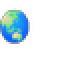

In [22]:
#@title Choose Target Image { vertical-output: true}

target_img = load_cell()
imshow(zoom(to_rgba(target_img), 2), fmt='png')

(60, 60, 4)


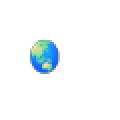

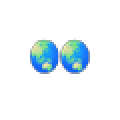

In [23]:
#@title Pull the images from github

target_img_1 = load_cell()
target_img_2 = load_Dcell()

h, w = target_img_1.shape[:2]

p = (TARGET_PADDED_SIZE - h) // 2
padded_img_1 = tf.pad(target_img_1, [[p, p], [p,p], [0,0]])
padded_img_2 = tf.pad(target_img_2, [[p, p], [p,p], [0,0]])

print(padded_img_1.shape)

imshow(zoom(to_rgba(padded_img_1),2),fmt='png')
imshow(zoom(to_rgba(padded_img_2),2),fmt='png')

In [9]:
#@title Initialize Training { vertical-output: true}


h, w = padded_img_1.shape[:2]
print(h,w)
seed = np.zeros([h, w, CHANNEL_N], np.float32)
seed[h//2, w//2, 3:]  = 1.0
seed[h//2, w//2, -ENV_N:] = 0.0

def loss_f(x, y):
  return tf.reduce_mean(tf.square(to_rgba(x)-to_rgba(y)), [-2, -3, -1])

ca = CAModel()

loss_log = []

lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [3000, 5000, 6000, 10000], [lr, lr*0.5, lr * 0.1, lr * 0.05, lr*0.01])
trainer = tf.keras.optimizers.Adam(lr_sched)


loss0 = loss_f(seed[None,...], padded_img_1[None,...]).numpy()

pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0),
                  y=np.repeat(padded_img_1[None, ...], POOL_SIZE, 0),
                  z=np.repeat(0, POOL_SIZE,0))

# !mkdir -p train_log && rm -f train_log/*

60 60


batch (before/after):


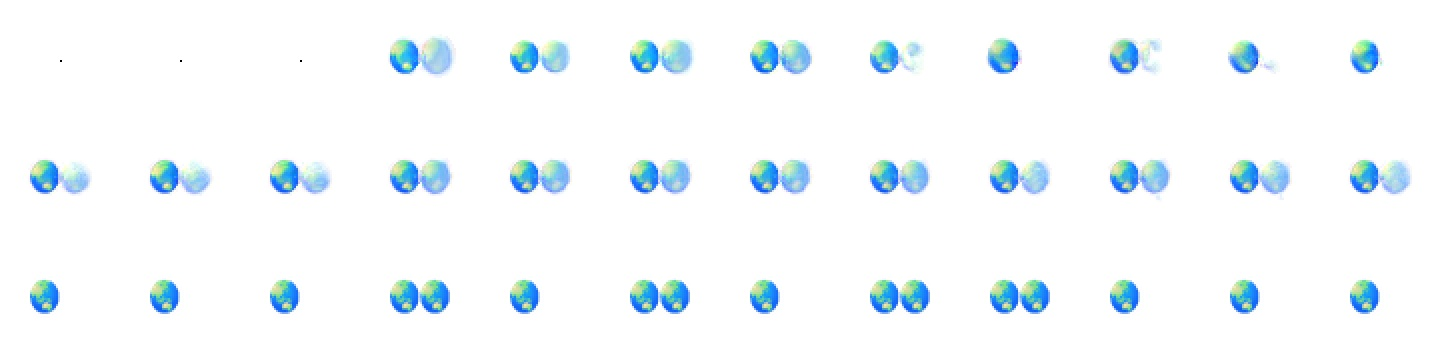

[0 0 0 1 2 1 2 1 1 0 0 0]


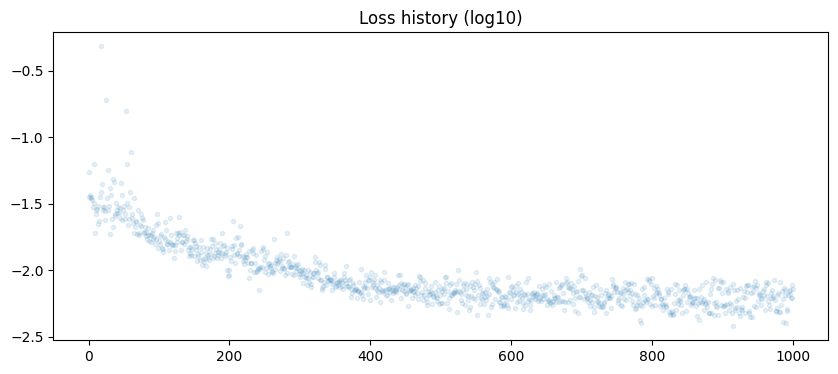

 step: 1077, log10(loss): -2.305
 0:05:38.153487


In [26]:
#@title Training Loop {vertical-output: true}

@tf.function
def train_step(x, y):
  iter_n = tf.random.uniform([], 64, 200, tf.int32)
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x, y))
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss


@tf.function
def make_seed_env():
  h, w = (TARGET_PADDED_SIZE, TARGET_PADDED_SIZE)
  seed = np.zeros([h, w, CHANNEL_N], np.float32)
  seed[h//2, w//2, 3:] = 1.0
  seed[h//2,w//2,-ENV_N:] = 0
  return seed


@tf.function
def get_target(numSignals):
  if numSignals % 2 == 0:
    target_img_scale = target_img_1
  else:
    target_img_scale = target_img_2

  img_w = target_img_scale.shape[:1][0]
  p = (TARGET_PADDED_SIZE - img_w) // 2
  pad_target_temp = tf.pad(to_rgba(target_img_scale), [[p, p], [p,p], [0,0]])
  return(pad_target_temp)


if fix_seed:
  tf.random.set_seed(1)

tic = datetime.datetime.now()
switch = 0
switch_step = 3
mirror = False

start_i = 6
end_i = 9
num_seeded = 3

for i in range(1000+1):

  if i == BEHAVIOUR_SWITCH:
    # move signal to middling outputs rather than best outputs
    # (keep training best outputs to persist)
    start_i    = 6
    end_i      = 12
    num_seeded = 1


  if USE_PATTERN_POOL:
    batch = pool.sample(BATCH_SIZE)
    x0 = batch.x
    y0 = batch.y
    z0 = batch.z
    loss_rank = loss_f(x0, y0).numpy().argsort()[::-1]
    x0 = x0[loss_rank]
    y0 = y0[loss_rank]
    z0 = z0[loss_rank]

    x0[:num_seeded] = make_seed_env()
    y0[:num_seeded] = get_target(0)
    z0[:num_seeded] = np.zeros(num_seeded)
    if DAMAGE_N:
      # get location of signal input:
      stim_x, stim_y = get_stim(jitter=True)

      x0[start_i:end_i, stim_y, stim_x, -ENV_N:] = 1.0
      z0[start_i:end_i]     += 1   # keep track of how many signals this NCA has been given
      for z in range(start_i, end_i):
        y0[z,...] = get_target(z0[z])

  else:
    seed = make_seed_env()
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)

  x, loss = train_step(x0, y0)

  if USE_PATTERN_POOL:
    batch.x[:] = x
    batch.y[:] = y0
    batch.z[:] = z0
    batch.commit()

  step_i = len(loss_log)
  loss_log.append(loss.numpy())

  if step_i%10 == 0:
    generate_pool_figures(pool, step_i)
  if step_i%100 == 0:
    clear_output()
    visualize_batch(x0, x, y0, step_i)
    print(z0)
    plot_loss(loss_log)
    export_model(ca, 'train_log/%04d.weights.h5'%step_i)

  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')
toc = datetime.datetime.now()
print("\n", toc - tic)
loading_from_file = False

# Figures

In [24]:
#@title Load model from file {vertical-output:true}
loading_from_file = False

if loading_from_file:
  print()
  # r = requests.get()
  # with open("model.zip", "wb") as f:
  #   f.write(r.content)
  # !cp gecko_colourchange_model.zip /content/model.zip
  # !rm -rf /content/model/
  # !mkdir /content/model/
  # !unzip -q -d /content/model/ /content/model.zip
  # !rm /content/model.zip

In [11]:
#@title Training Progress (Checkpoints)

model_nums = [100, 500, 1000]

if loading_from_file:
  # only 10000 is stored in the external file
  root_dir = '/content/model/'
  model_nums = [10000]
else:
  root_dir = ''

models = []
for i in model_nums:
  ca = CAModel()
  ca.load_weights(root_dir + 'train_log/%04d.weights.h5'%i)
  models.append(ca)


x = np.zeros([len(models), TARGET_PADDED_SIZE, TARGET_PADDED_SIZE, CHANNEL_N], np.float32)
x[..., TARGET_PADDED_SIZE//2, TARGET_PADDED_SIZE // 2, 3:] = 1.0
x[:, TARGET_PADDED_SIZE//2, TARGET_PADDED_SIZE//2, -ENV_N:] = 0.0

out_fn = 'cell_divide.mp4'

models2 = models.copy()
x2 = x.copy()
models3 = models.copy()
x3 = x.copy()
models4 = models.copy()
x4 = x.copy()

stim_xa,stim_ya = get_stim();
stim_xb,stim_yb = get_stim(jitter=True);
stim_xc,stim_yc = get_stim();


with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(1500):
    if i == 500 or i == 1000:

      stim_x, stim_y = get_stim()
      x2[:, stim_ya, stim_xa, -ENV_N:] = 1.0
      stim_x, stim_y = get_stim(jitter=True)
      x3[:, stim_yb, stim_xb, -ENV_N:] = 1.0
      stim_x, stim_y = get_stim()
      x4[:, stim_yc+1, stim_xc+1, -ENV_N:] = 1.0





    vis = np.hstack(to_rgb(x))
    vis2 = np.hstack(to_rgb(x2))
    vis3 = np.hstack(to_rgb(x3))
    vis4 = np.hstack(to_rgb(x4))
    vis5 = np.hstack(get_channels(x2, [5,6,7]))      #]
    vis6 = np.hstack(get_channels(x2, [8,9,10]))     #] visualise the hidden layers
    vis7 = np.hstack(get_channels(x2, [11,12,13]))   #]
    vis8 = np.hstack(get_channels(x2, [14,14,14]))   #]

    vis = np.vstack((
                      vis
                     ,vis2
                     ,vis3
                     ,vis4
                     ,vis5
                     ,vis6
                     ,vis7
                     ,vis8
    ))



    vid.add(zoom(vis, 2))
    for ca, xk in zip(models, x):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models2, x2):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models3, x3):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models4, x4):
      xk[:] = ca(xk[None,...])[0]

100%|██████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:06<00:00, 22.70it/s]


AttributeError: module 'moviepy' has no attribute 'ipython_display'

In [27]:
display_video('cell_divide.mp4')